In [ ]:
#Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Defining Parameters
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 10

train_dir = "/content/Training"
test_dir = "/content/Testing"

In [ ]:
#Data Pre-processing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
#Building CNN Model
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')   # 4 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Build Transfer Learning Model (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-2611786415.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#Training Model
base_model.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data
)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 61s 285ms/step - accuracy: 0.9412 - loss: 0.1796 - val_accuracy: 0.8886 - val_loss: 0.2994
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.9394 - loss: 0.1638 - val_accuracy: 0.9199 - val_loss: 0.2145
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9389 - loss: 0.1564 - val_accuracy: 0.9054 - val_loss: 0.2886
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9472 - loss: 0.1455 - val_accuracy: 0.9169 - val_loss: 0.2355
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9459 - loss: 0.1501 - val_accuracy: 0.9130 - val_loss: 0.2405
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9443 - loss: 0.1536 - val_accuracy: 0.9069 - val_loss: 0.2476
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.9468 - loss: 0.1386 - val_accuracy: 0.9191 - val_loss: 0.2223
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.9519 - loss: 0

In [ ]:
#Fine Tuning
# Unfreeze base model
base_model.trainable = True

# Freeze early layers (keep low-level features stable)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data
)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 319ms/step - accuracy: 0.9424 - loss: 0.1679 - val_accuracy: 0.9306 - val_loss: 0.1724
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9442 - loss: 0.1684 - val_accuracy: 0.9359 - val_loss: 0.1622
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9464 - loss: 0.1443 - val_accuracy: 0.9344 - val_loss: 0.1656
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9424 - loss: 0.1482 - val_accuracy: 0.9375 - val_loss: 0.1687
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.9457 - loss: 0.1480 - val_accuracy: 0.9397 - val_loss: 0.1558
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.9455 - loss: 0.1462 - val_accuracy: 0.9397 - val_loss: 0.1585
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.9554 - loss: 0.1264 - val_accuracy: 0.9451 - val_loss: 0.1505
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9627 - loss: 0

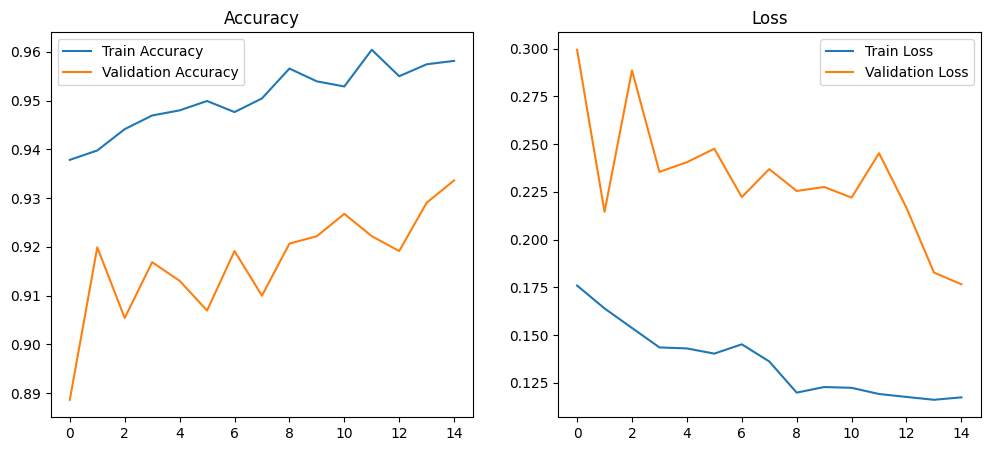

In [ ]:
#Plot Accuracy & Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       300
  meningioma       0.93      0.91      0.92       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



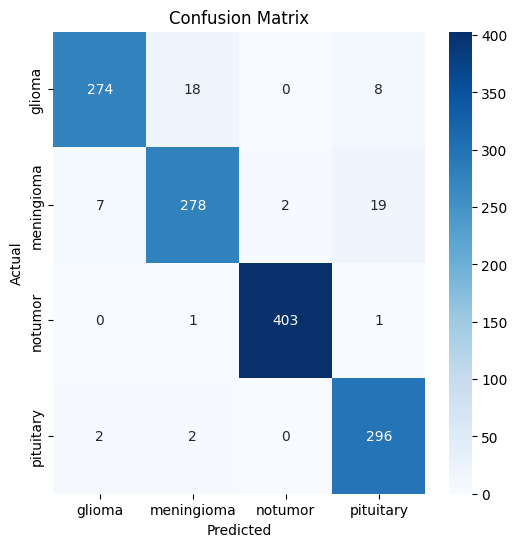

In [ ]:
#Confusion Matrix + Metrics
predictions = model.predict(val_data)
pred_classes = np.argmax(predictions, axis=1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

print(classification_report(true_classes, pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Grad-CAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


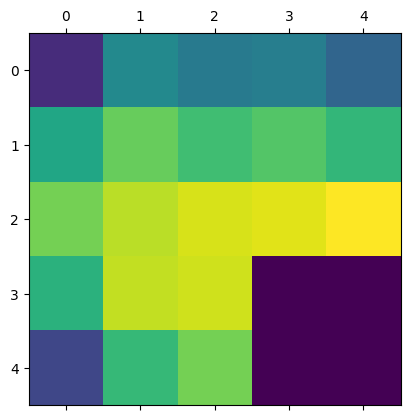

In [ ]:
#Testing Grad-CAM on one image
img_path = "/content/Testing/glioma/Te-glTr_0000.jpg"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = make_gradcam_heatmap(img_array, model, "Conv_1")

plt.matshow(heatmap)
plt.show()

In [ ]:
#Evaluate Model
loss, accuracy = model.evaluate(val_data)

print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9355 - loss: 0.2014
Validation Loss: 0.1347
Validation Accuracy: 95.42%


In [ ]:
model.save("/content/drive/MyDrive/brain_tumor_model.keras")
